In [1]:
# --------------- #
# Import Packages #
# --------------- #

# --- Base packages ---
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd

# --- Visualisation packages ---
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import altair as alt
from pandas.plotting import parallel_coordinates
import plotly.express as px

# --- Statistical packages ---
import math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# --- Mainly to supress Altair's warnings ---
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **RQ2**: _Are there similarities in crime types across districts?_

---

## A. Preliminaries

### A.1. Import Data

In [2]:
# Import crime data.
crimePerPop_long = pd.read_csv("data/0_crimePerPop_long.csv")
crimePerPop_long['location'] = crimePerPop_long['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')
crimePerPop_long = crimePerPop_long.set_index(['location', 'state', 'district'])

# Change from long to wide.
crimePerPop_wide = crimePerPop_long.reset_index()[['location', 'state', 'district']].drop_duplicates()
for y in crimePerPop_long.date.unique():
    df = crimePerPop_long[crimePerPop_long['date']==y].copy()
    df.columns = [x + "_" + str(y) for x in df.columns.values]
    crimePerPop_wide = crimePerPop_wide.merge(df, on=['location', 'state', 'district'])
crimePerPop_wide = crimePerPop_wide.set_index(['location', 'state', 'district'])


# Import geo data.
district_boundaries = gpd.read_file('data/district_boundaries.shp')

### A.2. Define Helper Functions
- getColor: Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
- process_df: Applies several pre-processing steps to the target DataFrame. These steps include scaling the data, reducing the dimension via MDS and applying PCA. The results are then visualised.
- cluster_helper: Helps to determine the optimal number of clusters by visualising the elbow method (within-cluster-sum-of-squartes) and silhoutte score(average intra-cluster distance).
- cluster_inspect: Visualises the silhoutte plots and spatial distribution of the clusters.

In [3]:
# ---------------- #
# Helper Functions #
# ---------------- #

def getColor(x, y, minX, maxX, minY, maxY):
    """
    Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
    """
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    if (wY < wX):   # scale vertically (i.e. modify rr) to make it a square
        rr *= wX/wY  
    else:           # scale horizontally (i.e. modify cc) to make it a square
        cc *= wY/wX
    maxD=max(wX,wY) # length of the 'square'
    rr1=maxD-rr     # distance from opposite end on the horizontal axis
    cc1=maxD-cc     # distance from opposite end on the vertical axis

    # List of distances from the various four corners
    dc=[math.sqrt(rr*rr+cc*cc), math.sqrt(rr*rr+cc1*cc1), math.sqrt(rr1*rr1+cc*cc), math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0, 0.0, 0.0, 0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0

    # Set the RGB values for the four corners
    reds=[228, 25, 255, 37]
    greens=[220, 228, 18, 13]
    blues=[0, 218, 6, 252]
    
    # Initialise RGB values = 0
    dr=0
    dg=0
    db=0

    # Calculate RGB values and cap at 255
    for i, weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr>255):
        dr=255
    if (dg>255):
        dg=255        
    if (db>255):
        db=255  

    # Create and return the relevant hex code
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string



def process_df(data, r_state=42, p_n_init=4, p_max_iter=300):
    """
    Applies several pre-processing steps to the target DataFrame. These steps include
    scaling the data, reducing the dimension via MDS and applying PCA. The results are
    then visualised.
    """
    # Standardise the data.
    scale = StandardScaler()
    data_scaled = scale.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

    # Apply MDS, reducing to 2 dimensions.
    mds_def = MDS(n_components=2, random_state=r_state)
    mds_def.fit_transform(data_scaled)

    mds = MDS(n_components=2, random_state=r_state, n_init=p_n_init, max_iter=p_max_iter)
    data_mds = mds.fit_transform(data_scaled)
    data_mds_df = pd.DataFrame(data_mds, columns=['xy_mds1', 'xy_mds2'], index=data.index)
    # Get a list of the colour scheme.
    warna = []
    for i in range(len(data_mds)):
         c=getColor(data_mds[i,0], data_mds[i,1],
                    data_mds[:,0].min(), data_mds[:,0].max(),
                    data_mds[:,1].min(), data_mds[:,1].max())
         warna.append(c) 
    warna_df = pd.DataFrame(warna, columns=['colours'], index=data.index)
    data_mds_df = data_mds_df.merge(warna_df, left_index=True, right_index=True)

    # Apply PCA, no restrictions on number of components.
    pca = PCA()
    pca.fit(data_scaled)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)    # Compute the cumulative explained variance
    n_components = np.argmax(cumulative_explained_variance >= 0.80) + 1         # Find the number of components for at least 80% explained variance

    # Visualise the MDS and PCA results.
    fig, axs = plt.subplots(1,3, figsize=(25,6))

    # Plot MDS results, with location annotation.
    for i in range(len(data_mds)):
        axs[0].scatter(data_mds[i,0], data_mds[i,1], alpha=0.9,
                    c=getColor(data_mds[i,0], data_mds[i,1],
                                data_mds[:,0].min(), data_mds[:,0].max(),
                                data_mds[:,1].min(), data_mds[:,1].max()))
        axs[0].text(data_mds[i,0]+0.05, data_mds[i,1]+0.05, data.reset_index(level=[1,2]).index[i], alpha=0.4)
    axs[0].set_xlabel("Axis 1")
    axs[0].set_ylabel("Axis 2")
    axs[0].set_title("MDS Projection (Location)")
    axs[0].grid(alpha=0.5, linestyle='--')

    # Plot MDS results, with district annotation.
    for i in range(len(data_mds)):
        axs[1].scatter(data_mds[i,0], data_mds[i,1], alpha=0.9,
                    c=getColor(data_mds[i,0], data_mds[i,1],
                                data_mds[:,0].min(), data_mds[:,0].max(),
                                data_mds[:,1].min(), data_mds[:,1].max()))
        axs[1].text(data_mds[i,0]+0.05, data_mds[i,1]+0.05, data.reset_index(level=[0,1]).index[i], alpha=0.4)
    axs[1].set_xlabel("Axis 1")
    axs[1].set_ylabel("Axis 2")
    axs[1].set_title("MDS Projection (District)")
    axs[1].grid(alpha=0.5, linestyle='--')


    axs[2].plot(range(1,13), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', linewidth=1)
    axs[2].set_title("Explained Variance by Components")
    axs[2].set_xlabel("Number of Components")
    axs[2].set_ylabel("Cumulative Explained Variance")

    plt.show()

    print("Default MSD stress:", mds_def.stress_)
    print("Optimised MDS stress:", mds.stress_)
    print(f"Number of components to retain at least 80% variance: {n_components}")

    return data_scaled, data_mds_df



def cluster_helper(data, k_min, k_max, c_random_state=42, c_n_init='auto', c_max_iter=300, data_title=''):
    """
    Helps to determine the optimal number of clusters by visualising the elbow
    method (within-cluster-sum-of-squartes) and silhoutte score (average intra-
    cluster distance).
    """
    wcss = []
    silhouette_scores = []
    k_range = range(k_min, k_max+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=c_random_state, n_init=c_n_init, max_iter=c_max_iter)
        cluster_labels = kmeans.fit_predict(data)
        wcss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Visualise the results
    plt.figure(figsize=(13, 4))

    # Plot the elbow curve
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, marker='o', linestyle='--', linewidth=1)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k '+ data_title)

    # Plot the silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker='o', color='green', linestyle='--', linewidth=1)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Optimal k '+ data_title)

    plt.tight_layout()
    plt.show()

    return None



def cluster_inspect(data_scaled, geo_data, k_list, c_random_state=42, c_n_init='auto', c_max_iter=300):
    """
    Visualises the silhoutte plots and spatial distribution of the clusters.
    """
    range_k = k_list
    cluster_df = {}

    for k in range_k:
        # Implement clustering
        kmeans = KMeans(n_clusters=k, random_state=c_random_state, n_init=c_n_init, max_iter=c_max_iter)
        cluster_labels = kmeans.fit_predict(data_scaled)
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)
        print("For n_clusters =", k, ", the average silhouette_score is :",silhouette_avg)

        lab_df = pd.DataFrame(cluster_labels, columns=['label'], index=data_scaled.index)
        lab_df_geo = pd.merge(geo_data, lab_df.reset_index(), on='district')

        # Plot the results
        fig, axs = plt.subplots(1,2, figsize=(20,5))

        y_lower = 3
        c_list = []
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / k)
            c_list.append(color)
            axs[0].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )
            axs[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 3
        axs[0].set_title("The silhouette plot for the various clusters")
        axs[0].set_xlabel("The silhouette coefficient values")
        axs[0].set_ylabel("Cluster label")
        axs[0].axvline(x=silhouette_avg, color="red", linestyle="--")
        axs[0].set_yticks([])
        axs[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        custom_cmap = ListedColormap(c_list)
        
        df_scaled = data_scaled.copy()  # Create a copy so that the insertion of label column does not affect the original dataset.
        df_scaled.insert(0, 'label', lab_df)
        name = "cluster_" + str(k)
        cluster_df[name] = df_scaled

        lab_df_geo.plot(ax=axs[1], column='label', cmap=custom_cmap)
        axs[1].set_xticks([])
        axs[1].set_yticks([])

        plt.show()

        data_scaled_pcp = df_scaled.copy()
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("crime_", "")
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("assault_", "a_")
        data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("property_", "p_")
        fig = px.parallel_coordinates(data_scaled_pcp.reset_index(drop=True),
                                      color="label",
                                      color_continuous_scale='jet')
        fig.show()

    return cluster_df

## B. Analysis Using All Districts Data

RQ1 showed that the temporal pattern for crime concentration tend to be stable, only the most recent data is used for the MDS projection to reduce the computational complexity.

In [4]:
# Extract detailed crime type data only for the year 2023.
df2023 = crimePerPop_long[crimePerPop_long['date']==2023].copy()
df2023_crimetype = df2023[df2023.columns[df2023.columns.str.startswith("crime_assault_")]].copy()
df2023_crimetype = df2023_crimetype.merge(df2023[df2023.columns[df2023.columns.str.startswith("crime_property_")]], right_index=True, left_index=True)

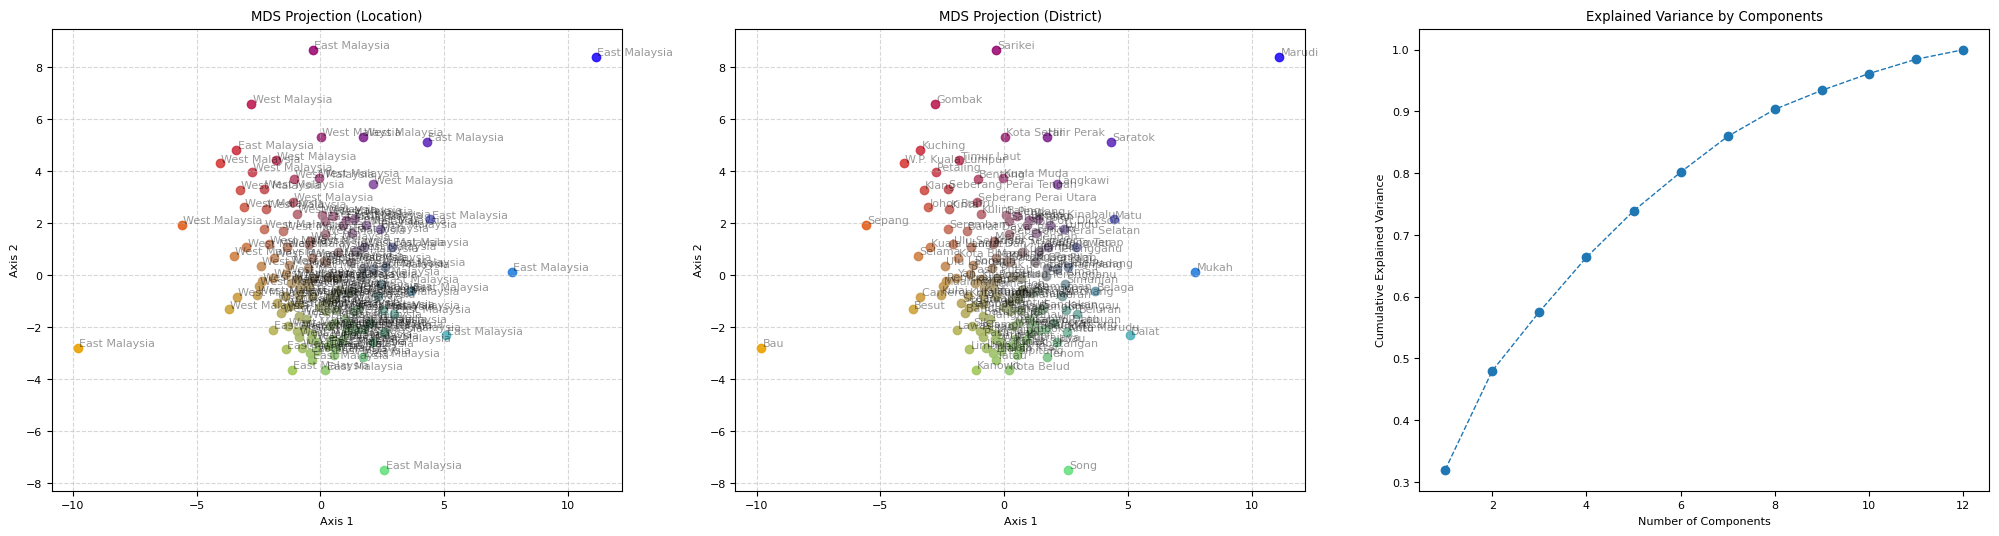

Default MSD stress: 8849.186743220456
Optimised MDS stress: 8561.497800471487
Number of components to retain at least 80% variance: 6


In [5]:
df_scaled, df_mds = process_df(df2023_crimetype, r_state=42, p_n_init=10000, p_max_iter=100000)

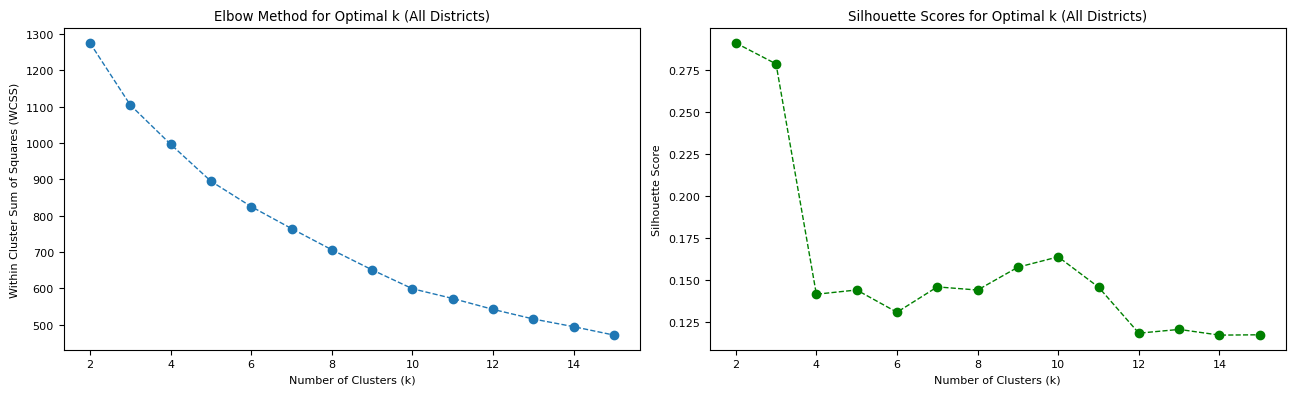

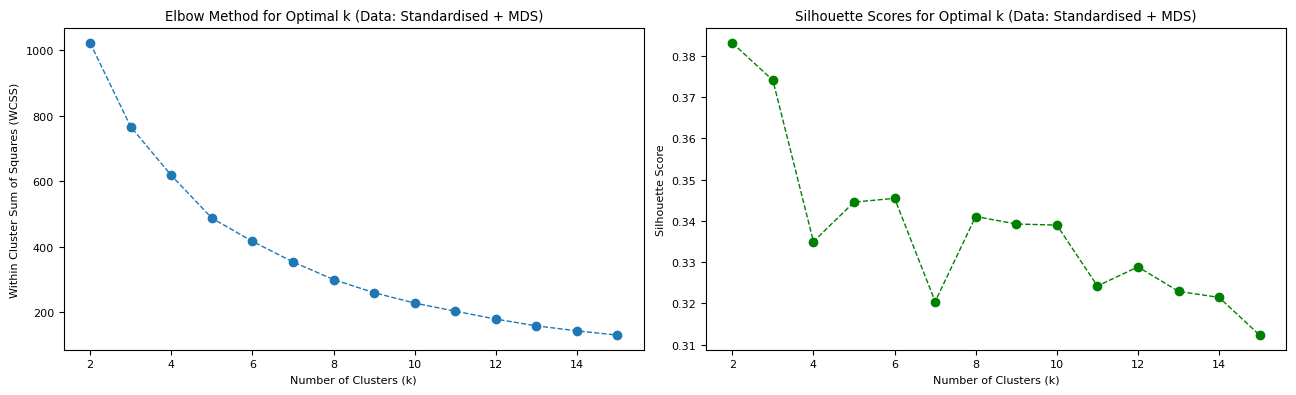

In [6]:
# Clustering with data transformation: standardised
cluster_helper(df_scaled, 2, 15, c_random_state=42, c_n_init=10000, c_max_iter=100000, data_title='(All Districts)')

# Clustering with data transformation: standardised and MDS
cluster_helper(df_mds.drop('colours', axis=1), 2, 15, c_random_state=42, c_n_init=10000, c_max_iter=100000, data_title='(Data: Standardised + MDS)')

For n_clusters = 2 , the average silhouette_score is : 0.29103688174606224


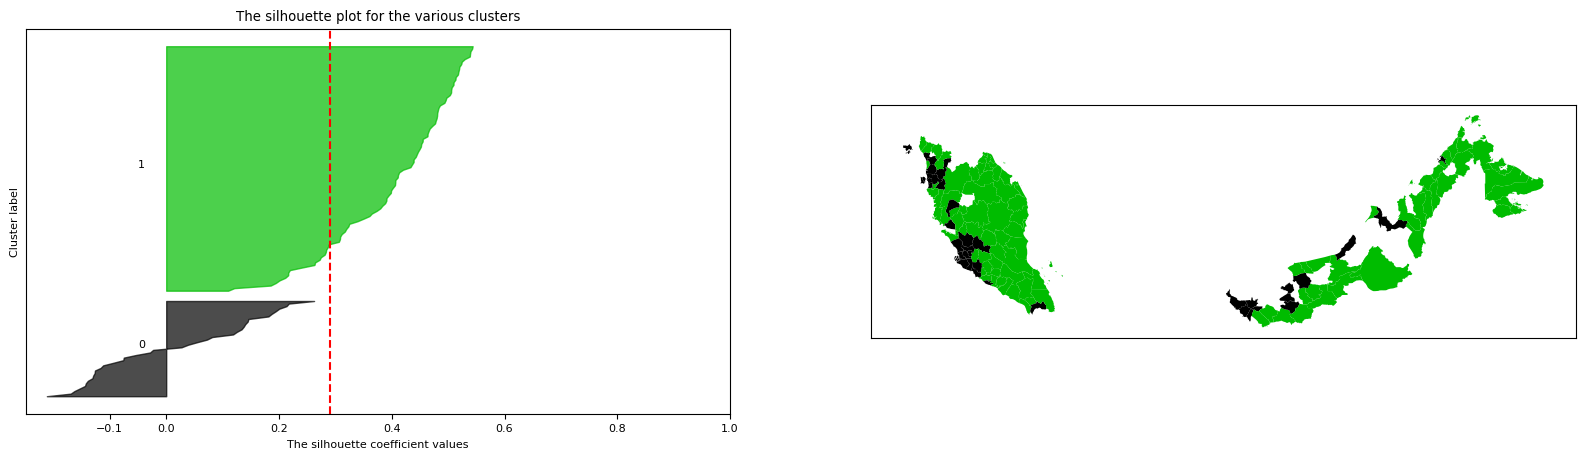

For n_clusters = 3 , the average silhouette_score is : 0.2785550301590471


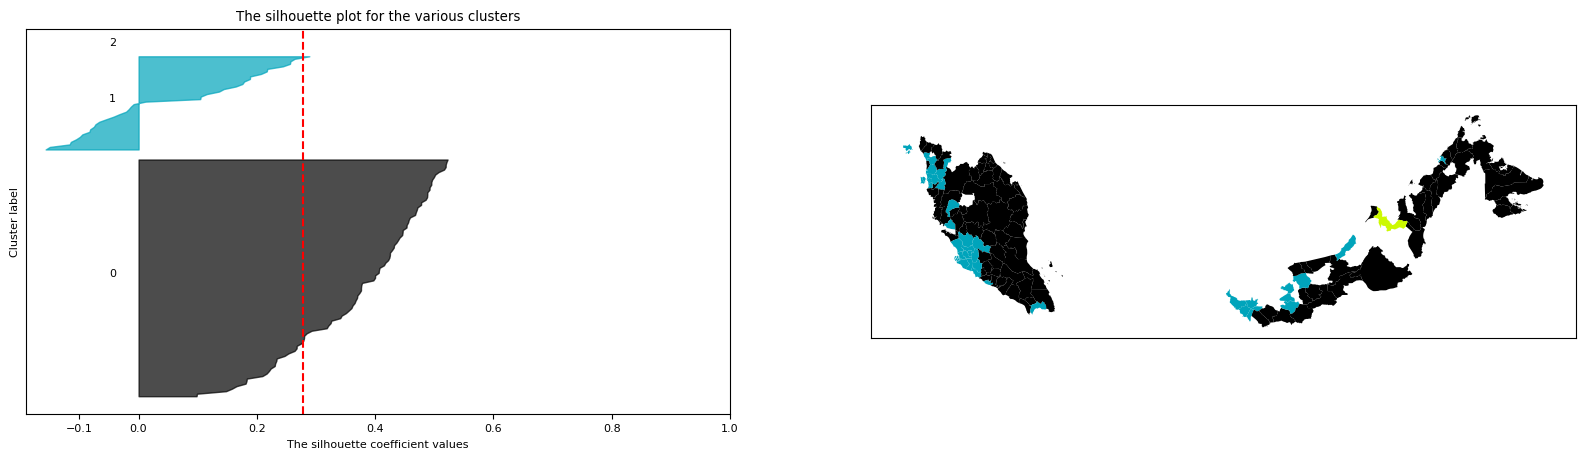

For n_clusters = 5 , the average silhouette_score is : 0.14395649545707506


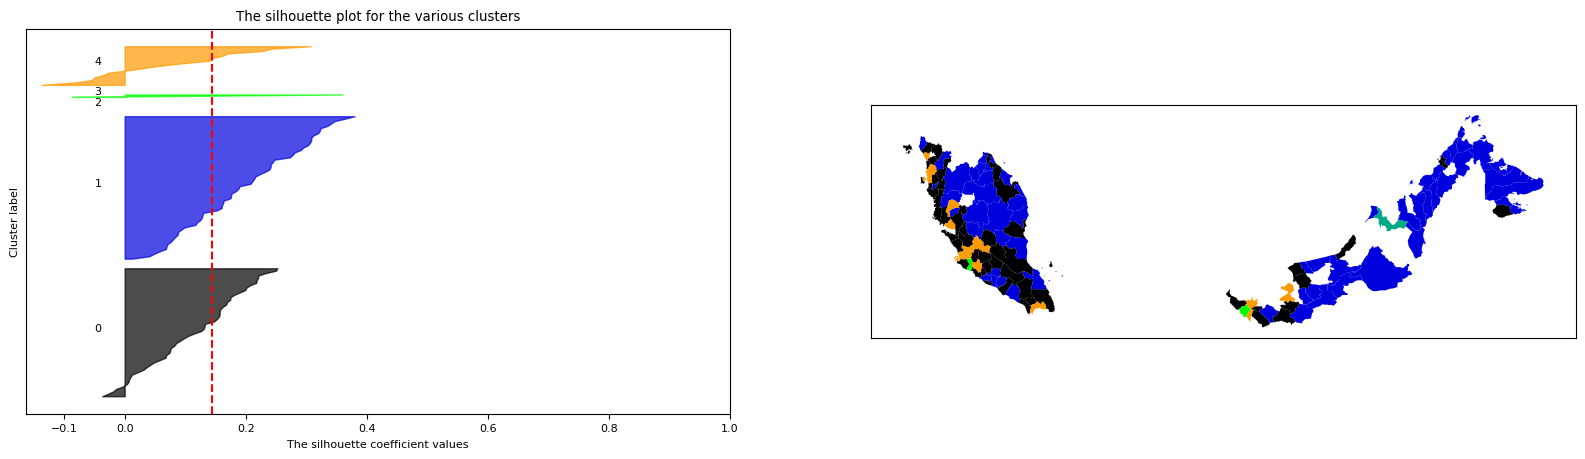

For n_clusters = 6 , the average silhouette_score is : 0.13069219790770328


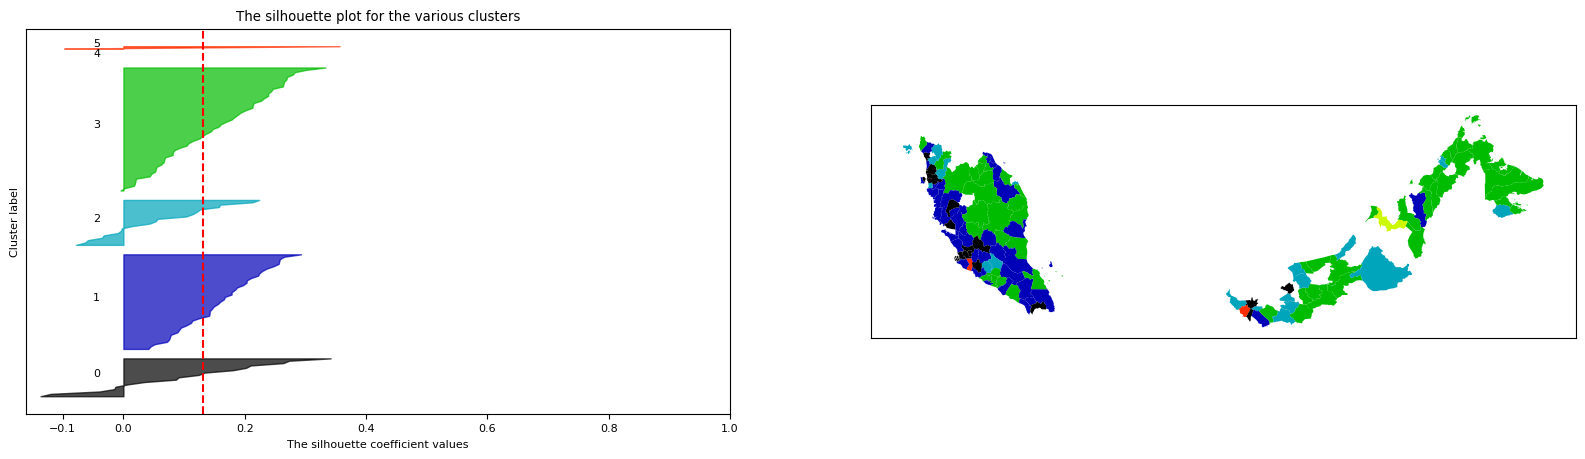

In [7]:
clusters_df = cluster_inspect(df_scaled, district_boundaries, [2, 3, 5, 6], c_random_state=42, c_n_init=10000, c_max_iter=100000)

## C. Analysis Excluding Outliers

From MDS projection of all districts, several East Malaysia districts seem to be outliers. Remove them - Marudi, Mukah, Bau.

In [8]:
# Remove districts: Marudi, Mukah, Bau
districts_to_drop = [('East Malaysia', 'Sarawak', 'Marudi'), ('East Malaysia', 'Sarawak', 'Mukah'), ('East Malaysia', 'Sarawak', 'Bau')]
df2023_crimetype_mod = df2023_crimetype.drop(districts_to_drop)

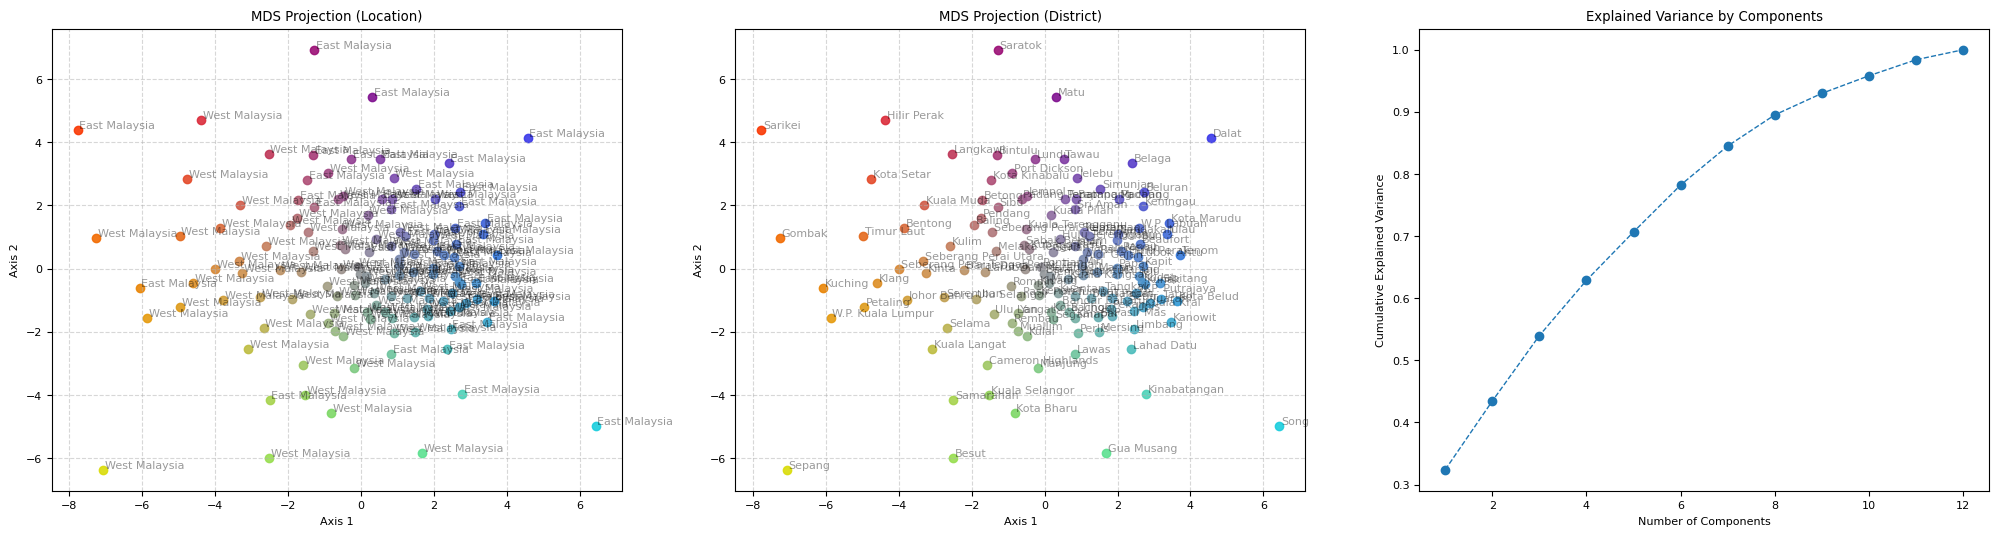

Default MSD stress: 11025.791779338728
Optimised MDS stress: 10193.645373563286
Number of components to retain at least 80% variance: 7


In [9]:
df_scaled_mod, df_mds_mod = process_df(df2023_crimetype_mod, r_state=42, p_n_init=10000, p_max_iter=100000)

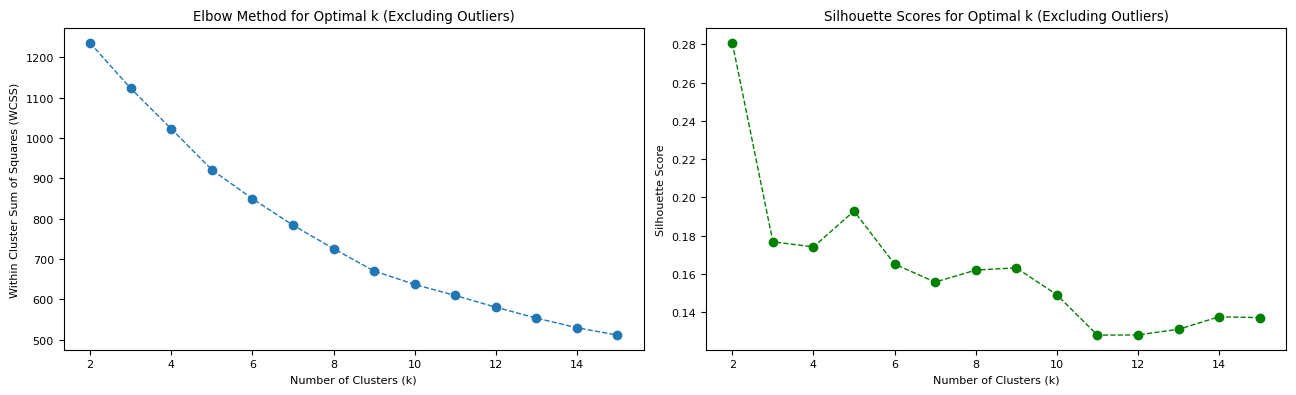

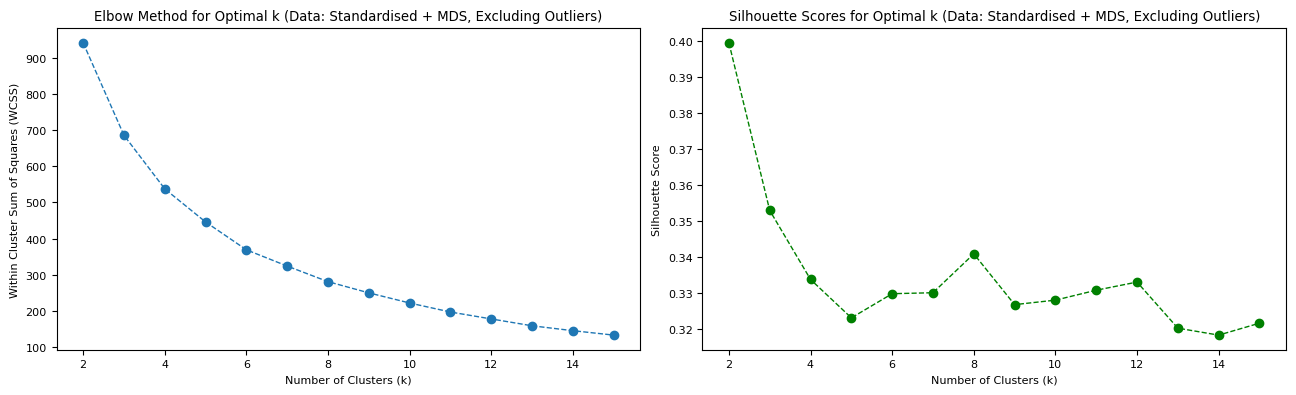

In [10]:
# Clustering with data transformation: standardised
cluster_helper(df_scaled_mod, 2, 15, c_random_state=42, c_n_init=10000, c_max_iter=100000, data_title='(Excluding Outliers)')

# Clustering with data transformation: standardised and MDS
cluster_helper(df_mds_mod.drop('colours', axis=1), 2, 15, c_random_state=42, c_n_init=10000, c_max_iter=100000, data_title='(Data: Standardised + MDS, Excluding Outliers)')

For n_clusters = 2 , the average silhouette_score is : 0.28071248188515224


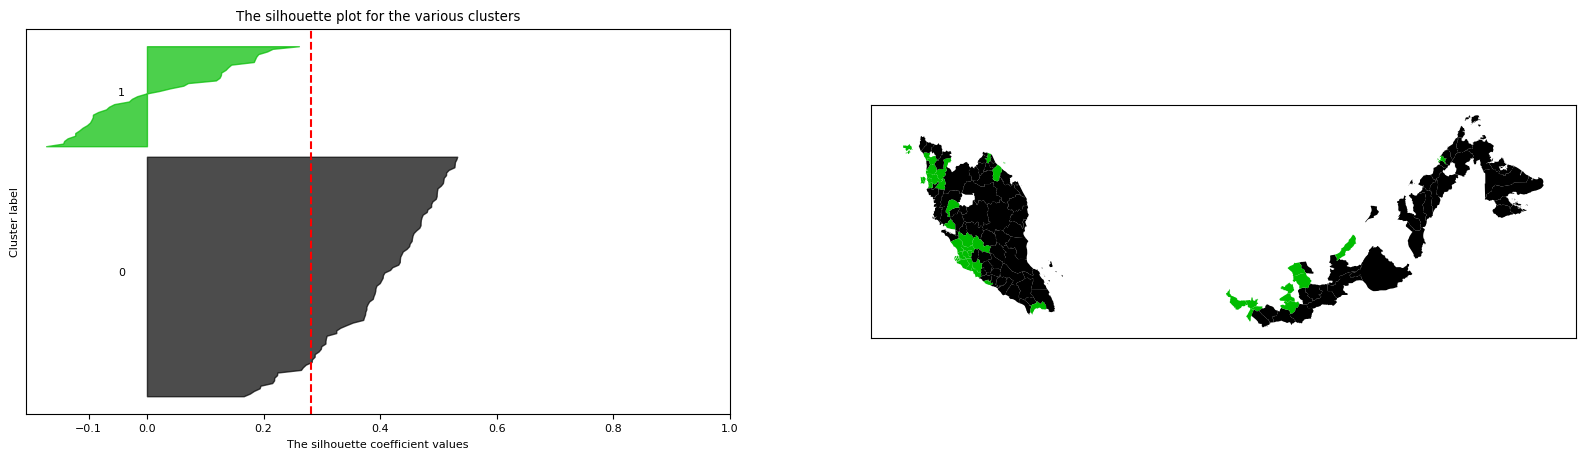

For n_clusters = 3 , the average silhouette_score is : 0.17679999480998035


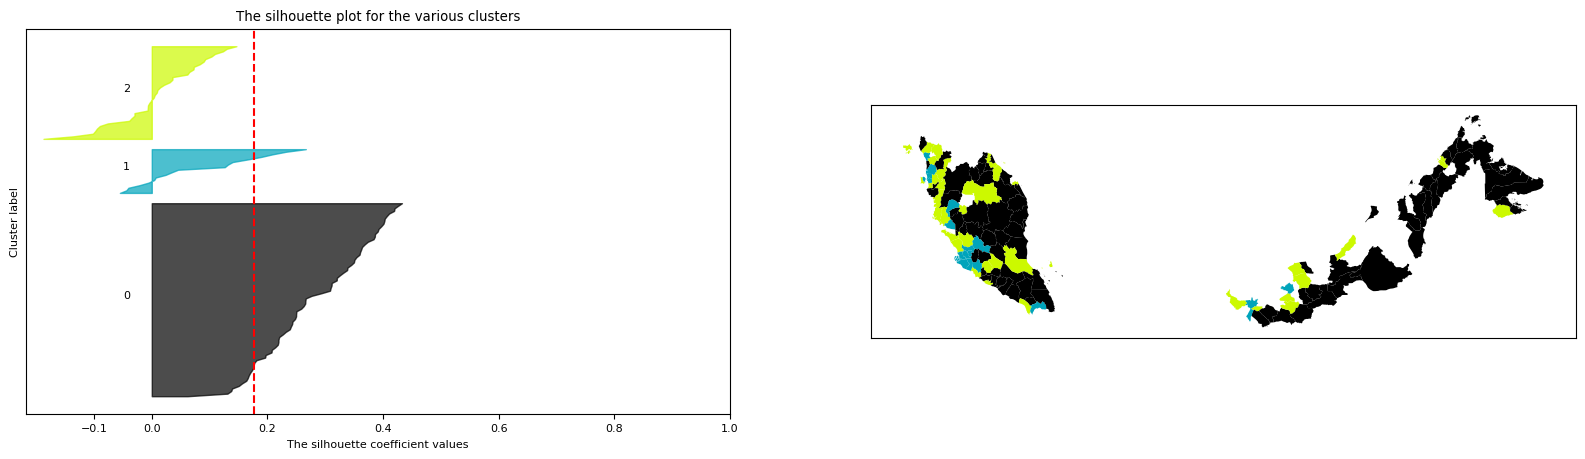

For n_clusters = 4 , the average silhouette_score is : 0.17413321426398506


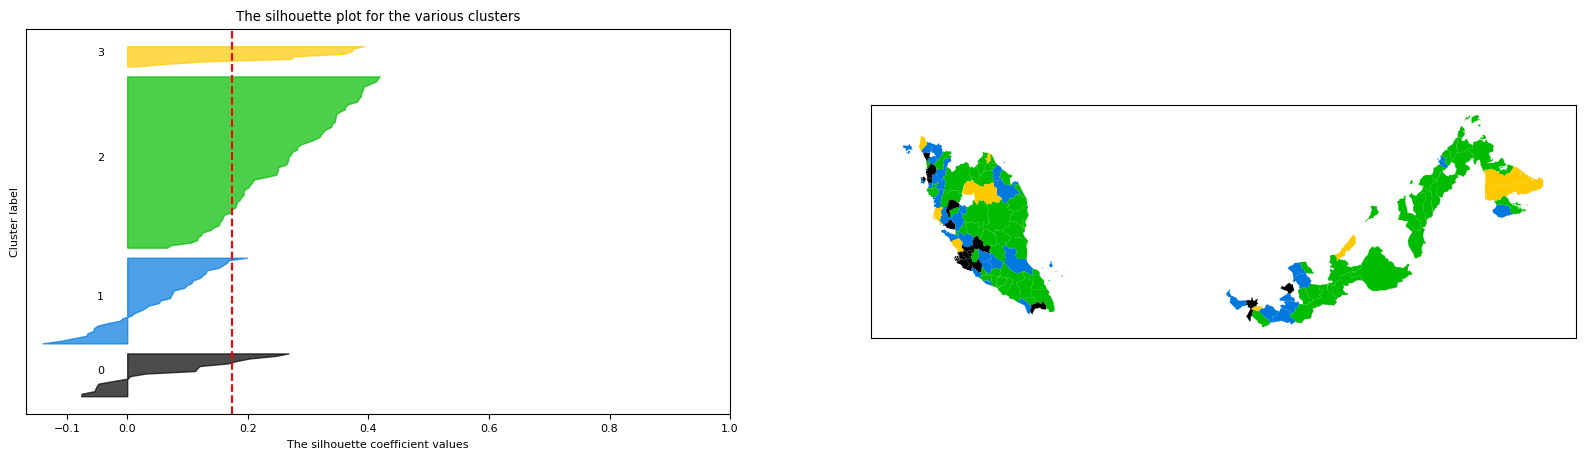

For n_clusters = 5 , the average silhouette_score is : 0.19288599831608003


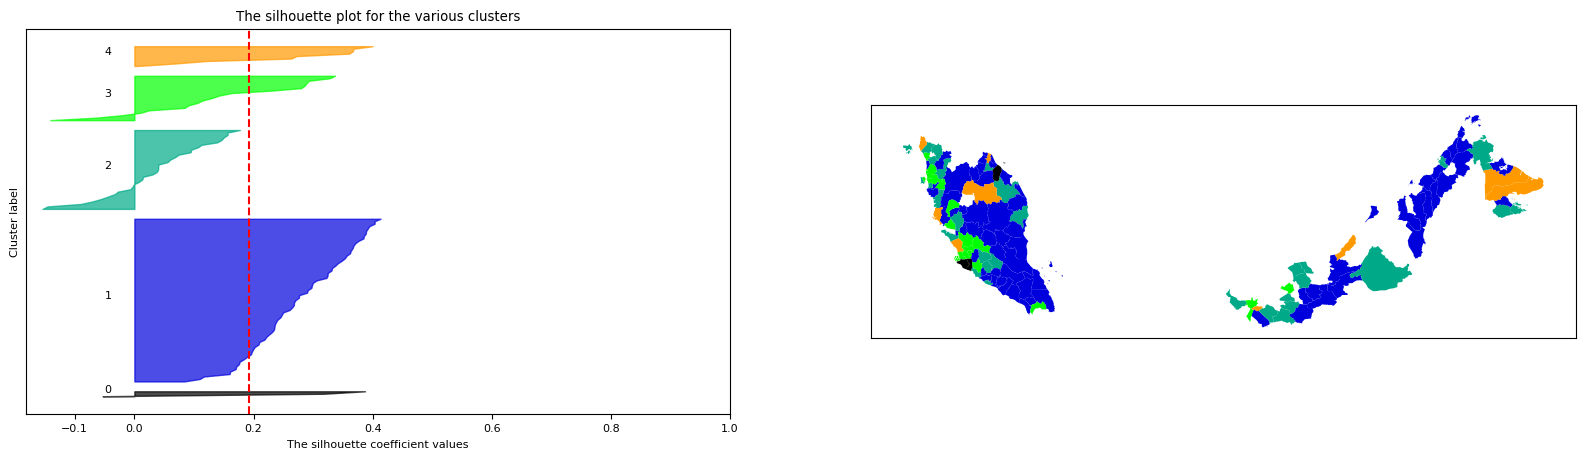

In [11]:
clusters_df_mod = cluster_inspect(df_scaled_mod, district_boundaries, [2, 3, 4, 5], c_random_state=42, c_n_init=10000, c_max_iter=100000)

## D. Save Clustered Dataset to Folder

In [ ]:
# Uncomment the final line to save.

ClusterCrime2023 = df2023.merge(clusters_df_mod['cluster_4'].label, on=['location', 'state', 'district'], how='outer').fillna(-1)
label_mod = {-1:-1, 2:1, 1:2, 0:3, 3:4}
ClusterCrime2023['crime_level'] = ClusterCrime2023['label'].map(label_mod).astype('int')
ClusterCrime2023 = ClusterCrime2023.reset_index()
#ClusterCrime2023.to_csv("data/1_ClusterCrime2023.csv", index=False)

## E. Figures to be Showcased In Report

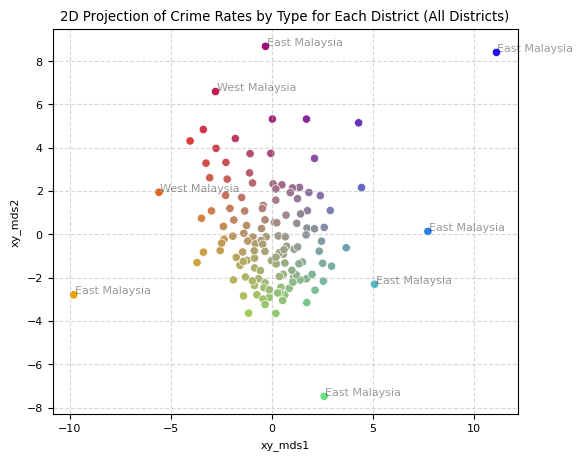

In [13]:
fig, axs = plt.subplots(1,1, figsize=(6, 5))

sns.scatterplot(data=df_mds, x='xy_mds1', y='xy_mds2', ax=axs, c=df_mds.colours)
for i in range(len(df_mds)):
    if np.abs(df_mds.iloc[i,0])>5 or np.abs(df_mds.iloc[i,1])>6:
        axs.text(df_mds.iloc[i,0]+0.05, df_mds.iloc[i,1]+0.05, df_mds.reset_index(level=[1,2]).index[i], alpha=0.4)
axs.grid(alpha=0.5, linestyle='--')
axs.set_title("2D Projection of Crime Rates by Type for Each District (All Districts)")

plt.show()

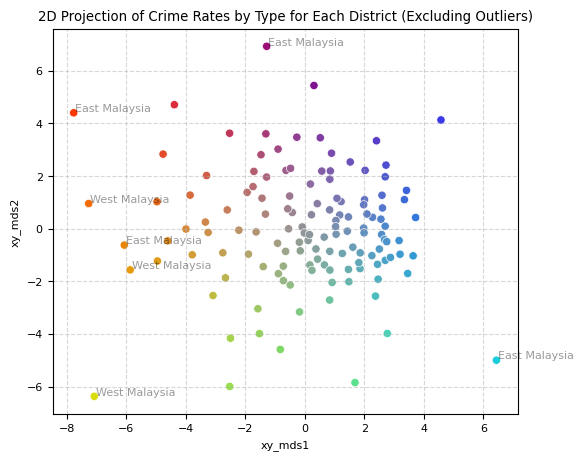

In [14]:
fig, axs = plt.subplots(1,1, figsize=(6, 5))

sns.scatterplot(data=df_mds_mod, x='xy_mds1', y='xy_mds2', ax=axs, c=df_mds_mod.colours)
for i in range(len(df_mds_mod)):
    if np.abs(df_mds_mod.iloc[i,0])>5 or np.abs(df_mds_mod.iloc[i,1])>6:
        axs.text(df_mds_mod.iloc[i,0]+0.05, df_mds_mod.iloc[i,1]+0.05, df_mds_mod.reset_index(level=[1,2]).index[i], alpha=0.4)
axs.grid(alpha=0.5, linestyle='--')
axs.set_title("2D Projection of Crime Rates by Type for Each District (Excluding Outliers)")

plt.show()

In [15]:
c4 = clusters_df_mod['cluster_4'].copy()
c4_geo = pd.merge(district_boundaries, c4.label.reset_index(), on='district')

label_mod = {-1:-1, 2:1, 1:2, 0:3, 3:4}
c4['label'] = c4['label'].map(label_mod).astype('int')
c4_geo['label'] = c4_geo['label'].map(label_mod).astype('int')


alt.Chart(c4_geo[c4_geo['location']=='West Malaysia']).mark_geoshape(strokeWidth=1,stroke='pastel1',strokeOpacity=0.2
).encode(
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
).properties(
    width=300,
    height=300
)

alt.Chart(...)

In [16]:
alt.Chart(c4_geo[c4_geo['location']=='East Malaysia']).mark_geoshape(strokeWidth=1,stroke='pastel1',strokeOpacity=0.2
).encode(
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
).properties(
    width=300,
    height=300
)

alt.Chart(...)

In [17]:
data_scaled_pcp = c4.copy()
data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("crime_", "")
data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("assault_", "a_")
data_scaled_pcp.columns = data_scaled_pcp.columns.str.replace("property_", "p_")
fig = px.parallel_coordinates(data_scaled_pcp.reset_index(drop=True),
                                color="label",
                                color_continuous_scale='jet')
fig.show()